<a href="https://colab.research.google.com/github/fovi-com/MLTradingBot/blob/main/Notebooks/5.%20LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an LSTM model to predict the price of the S&P 500

- LSTM stands for Long Short Term Memory

The LSTM cell contains an RNN cell inside (dense layer with a tanh activation function), but it has other attributes that allow it to remember patterns over a longer period of time. The LSTM contains a short-term state vector that is used from one time step to the next identical to the RNN cell.

Where LSTM cells differ is their Long-Term State vector. This long term state vector undergoes a multipicative and additive operation at each time step.The long term state vector starts off with a "forget gate" which is simply a sigmoid activation on top of a dense layer which produces an output from 0 - 1. This means if the forget gate ourputs a value of 1 then the long term state vector remains unchanged. On the opposite end, if the output valuse of the dense layer is 0 the long term state vector is nullified. This helps adjust quickly to highly volatile environments. If we are in a steady uptrend and then we suddenly have a big drop in the market, the long term state vector will be erased so the model can readjust quickly.

The next gate is the input gate. The input gate is much like the forget gate, except it decides if the short term state vector gets added to the long term vector or is erased.

The last gate called the "output gate" decides what the next hidden state should be. It is important to know that this hidden state output is the prediction for the next time step. Here, the previous hidden state (previous cell output) amd current input are jammed together through sigmoid function. Then we take our newly modified long term state vector which has already passed through the forget and input gates, and apply a tanh function to it. Finally, multiple both the tanh output (long term state vector output) and the sigmoid function output (previous hidden state and new input at this time step) to what information the hidden state needs to carry to the next time step.

</br>
<b>To review, the Forget gate decides what is relevant to keep from prior steps. The input gate decides what information is relevant to add from the current step. The output gate determines what the next hidden state should be.</b>

## Setup

In [1]:
%pip install numpy matplotlib tensorflow seaborn scikit-learn lumibot "keras==2.15.0" "pandas==2.0.3" "ipython==7.34.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.1/248.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 28.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of lumibot to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.1/248.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.1/248.1 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.9/247.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.9/247.9 kB 13.4 MB/s eta 0:00:00


In [2]:
# Are we in Google Colab?
try:
    import os
    from google.colab import drive
    print("Google Colab")
    # This will prompt for authorization.
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    print("Local file system")
    IN_COLAB = False

# Get into the right directory if we're in Google Colab
if IN_COLAB:
    import os
    os.makedirs("/content/drive/MyDrive/Machine Learning/SPY-Time-Series-Predictions", exist_ok=True)
    %cd /content/drive/MyDrive/Machine Learning/SPY-Time-Series-Predictions

%pwd

Google Colab
Mounted at /content/drive
/content/drive/MyDrive/Machine Learning/SPY-Time-Series-Predictions


'/content/drive/MyDrive/Machine Learning/SPY-Time-Series-Predictions'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

# set style of charts
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

In [4]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [5]:
import os

# Does the SPY file exist?
if not os.path.exists('SPY.csv'):
    if os.path.exists('../SPY.csv'):
        # The file is in the parent directory in the GitHub repo
        os.symlink('../SPY.csv', 'SPY.csv')
    else:
        # Download the file from GitHub
        import requests
        url = 'https://github.com/bsamaha/SPY-Time-Series-Predictions/raw/master/SPY.csv'
        r = requests.get(url)
        with open('SPY.csv', 'wb') as f:
            f.write(r.content)

# Read in data
spy = pd.read_csv('SPY.csv')

# Convert series into datetime type
spy['Date'] = pd.to_datetime(spy['Date'])

spy

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1993-01-29,26.20,26.20,26.07,26.18,1003200,0.0,0
1,1993-02-01,26.20,26.37,26.20,26.37,480500,0.0,0
2,1993-02-02,26.35,26.44,26.30,26.43,201300,0.0,0
3,1993-02-03,26.46,26.72,26.44,26.71,529400,0.0,0
4,1993-02-04,26.80,26.87,26.50,26.82,531500,0.0,0
...,...,...,...,...,...,...,...,...
6945,2020-08-27,348.51,349.90,346.53,348.33,58034100,0.0,0
6946,2020-08-28,349.44,350.72,348.15,350.58,48588900,0.0,0
6947,2020-08-31,350.35,351.30,349.06,349.31,66099200,0.0,0
6948,2020-09-01,350.21,352.71,349.24,352.60,54908700,0.0,0


In [6]:
# Save target series
series = spy['Close']

# Create train data set
train_split_date = '2014-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

5521 5522 6527 6528 6949


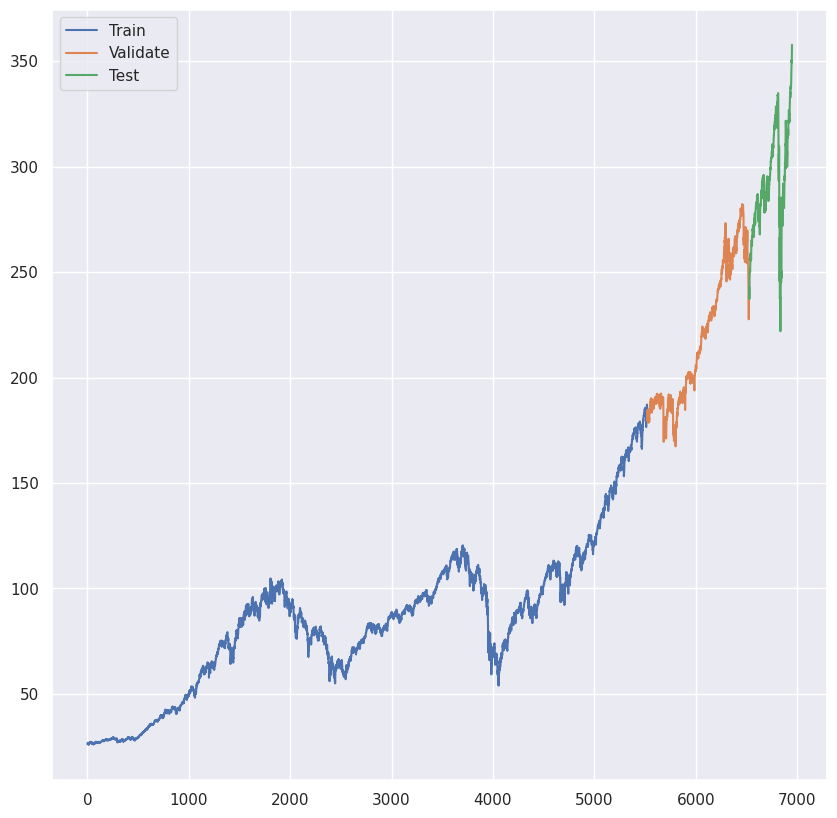

In [7]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [8]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

In [9]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## Find the learning Rate

In [10]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Set window size and create input batch sequences
window_size = 20
train_set = sequential_window_dataset(normalized_x_train, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# create lr
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

# choose optimizer
# WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Nadam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Nadam`.
# WARNING:absl:`lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Nadam.
# optimizer = keras.optimizers.Nadam(lr=1e-5)
optimizer = keras.optimizers.legacy.Nadam(learning_rate=1e-5)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# set history
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
276/276 [==============================] - 9s 7ms/step - loss: 0.0075 - mae: 0.0943 - lr: 1.0000e-05
Epoch 2/100
276/276 [==============================] - 2s 7ms/step - loss: 7.1081e-04 - mae: 0.0270 - lr: 1.1220e-05
Epoch 3/100
276/276 [==============================] - 2s 7ms/step - loss: 4.4159e-04 - mae: 0.0217 - lr: 1.2589e-05
Epoch 4/100
276/276 [==============================] - 2s 7ms/step - loss: 2.8559e-04 - mae: 0.0182 - lr: 1.4125e-05
Epoch 5/100
276/276 [==============================] - 3s 9ms/step - loss: 2.0398e-04 - mae: 0.0158 - lr: 1.5849e-05
Epoch 6/100
276/276 [==============================] - 2s 8ms/step - loss: 1.6515e-04 - mae: 0.0143 - lr: 1.7783e-05
Epoch 7/100
276/276 [==============================] - 2s 7ms/step - loss: 1.4727e-04 - mae: 0.0134 - lr: 1.9953e-05
Epoch 8/100
276/276 [==============================] - 2s 7ms/step - loss: 1.3857e-04 - mae: 0.0128 - lr: 2.2387e-05
Epoch 9/100
276/276 [==============================] - 2s 7ms/step -

(1e-08, 1.0, 0.0, 0.01)

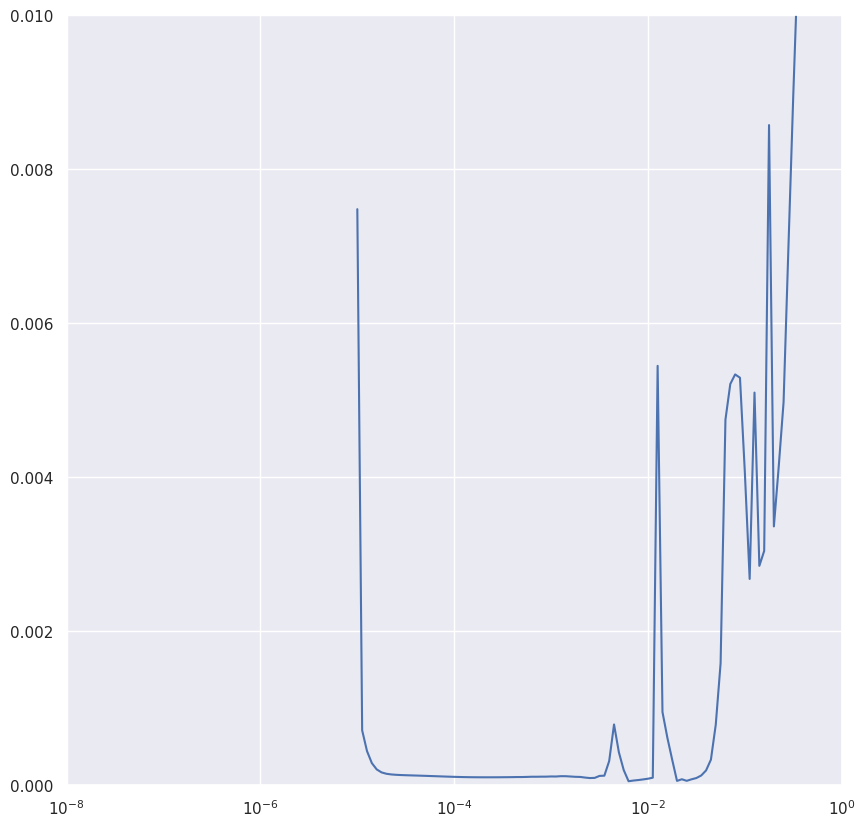

In [11]:
# Plot the learning rate chart
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1, 0, 0.01])

## Build and Train LSTM Model

In [12]:
# reset any stored data
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# set window size and create input batch sequence
window_size = 30
train_set = sequential_window_dataset(normalized_x_train, window_size)
valid_set = sequential_window_dataset(normalized_x_valid, window_size)

# create model
model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
])

# set optimizer
optimizer = keras.optimizers.legacy.Nadam(learning_rate=1e-4)

# compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# reset states
reset_states = ResetStatesCallback()

#set up save best only checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# fit model
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
184/184 [==============================] - 11s 47ms/step - loss: 1.9432e-04 - mae: 0.0141 - val_loss: 0.0052 - val_mae: 0.0756
Epoch 2/500
184/184 [==============================] - 8s 41ms/step - loss: 2.4925e-04 - mae: 0.0151 - val_loss: 0.0027 - val_mae: 0.0547
Epoch 3/500
184/184 [==============================] - 7s 36ms/step - loss: 1.3291e-04 - mae: 0.0120 - val_loss: 0.0019 - val_mae: 0.0460
Epoch 4/500
184/184 [==============================] - 8s 44ms/step - loss: 1.2049e-04 - mae: 0.0112 - val_loss: 0.0016 - val_mae: 0.0428
Epoch 5/500
184/184 [==============================] - 8s 41ms/step - loss: 1.1473e-04 - mae: 0.0108 - val_loss: 0.0015 - val_mae: 0.0410
Epoch 6/500
184/184 [==============================] - 7s 40ms/step - loss: 1.0970e-04 - mae: 0.0106 - val_loss: 0.0014 - val_mae: 0.0395
Epoch 7/500
184/184 [==============================] - 7s 36ms/step - loss: 1.0517e-04 - mae: 0.0104 - val_loss: 0.0013 - val_mae: 0.0382
Epoch 8/500
184/184 [============

## Make Predictions

In [13]:
# recall best model
model = keras.models.load_model("my_checkpoint")

In [14]:
# make predictions
rnn_forecast = model.predict(normalized_x_test[np.newaxis,:])
rnn_forecast = rnn_forecast.flatten()


1/1 [==============================] - 1s 655ms/step


In [15]:
# Example of how to invert
rnn_unscaled_forecast = x_train_scaler.inverse_transform(rnn_forecast.reshape(-1,1)).flatten()
rnn_unscaled_forecast.shape

(422,)

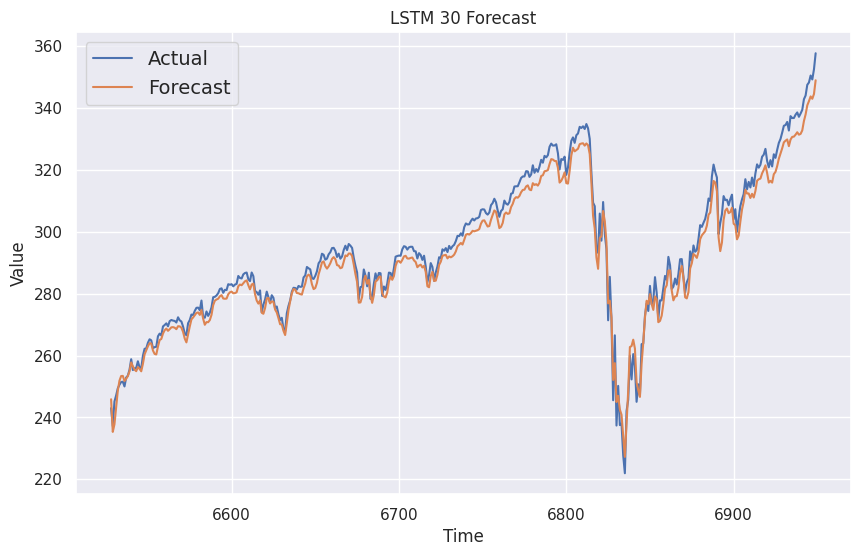

In [16]:
# plot results
plt.figure(figsize=(10,6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'LSTM {window_size} Forecast')
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, rnn_unscaled_forecast, label="Forecast")
plt.show()

In [17]:
# calculate MAE
keras.metrics.mean_absolute_error(x_test, rnn_unscaled_forecast).numpy()

3.3395226

This MAE (3.34) is even worse than what I got on my MacBook (2.53).  The RNG seed is set (to 42) for all runs so this isn't some sampling variation afacit.  It will take rerunning the other notebooks to see how the algorithm ranking works out but definitely need to give Naive Bayes a whirl.

The whole series and analysis by Blake Samaha is here:
https://github.com/bsamaha/SPY-Time-Series-Predictions

MAE value in Blake's notebook was 1.1875452.  This value (2.53) seems quite a bit worse, at least in percentage change.
In the comparison that Blake did LSTM 30 was way better at 1.19 than naive (2.72) and ARIMA (2.79) but this 2.53 doesn't seem very significant.
Is this due to library change or just expected variance for these runs?

[SPY-Time-Series-Predictions/Notebooks
/1. Time Series Forecasting with Naive, Moving Averages, and ARIMA.ipynb](https://github.com/bsamaha/SPY-Time-Series-Predictions/blob/master/Notebooks/1.%20Time%20Series%20Forecasting%20with%20Naive%2C%20Moving%20Averages%2C%20and%20ARIMA.ipynb)
